In [1]:
import os
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import pickle
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import scipy.ndimage.morphology as morph
from scipy.ndimage.filters import median_filter
import scipy.ndimage
from skimage.measure import regionprops
import pandas as pd

#import bat_train.evaluate as evl
from scipy.io import wavfile
#from helper_fns import *

In [2]:
test_set      = 'norfolk'  # can be one of: bulgaria, uk, norfolk
data_set      = 'bat_train/data/train_test_split/test_set_' + test_set + '.npz'
raw_audio_dir = 'bat_train/data/wav/'
clip_audio_dir= 'bat_train/data/wav_clips/'
base_line_dir = 'bat_train/data/baselines/'
result_dir    = 'bat_train/results/'
model_dir     = 'bat_train/data/models/'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
print('test set:', test_set)
plt.close('all')

test set: norfolk


In [3]:
classes = ['not_bat', 'bat']

In [4]:
#os.listdir(clip_audio_dir+test_set)
non_bat_dir = clip_audio_dir+test_set+'/'+classes[0]+'/'
bat_dir     = clip_audio_dir+test_set+'/'+classes[1]+'/'

In [5]:
bat_paths     = [bat_dir + fn for fn in os.listdir(bat_dir)]
non_bat_paths = [non_bat_dir + fn for fn in os.listdir(non_bat_dir)]

In [6]:
from random import shuffle

In [7]:
shuffle(bat_paths)
shuffle(non_bat_paths)

In [8]:
train_perc = 0.8
bat_cutoff = int(train_perc*len(bat_paths))
non_bat_cutoff = int(train_perc*len(non_bat_paths))

In [9]:
train_paths = bat_paths[:bat_cutoff]
train_paths.extend(non_bat_paths[:non_bat_cutoff])
test_paths = bat_paths[bat_cutoff:]
test_paths.extend(non_bat_paths[non_bat_cutoff:])

In [10]:
shuffle(train_paths)
shuffle(test_paths)

In [11]:
#TODO: define functions that get the different channels, e.g. regular spectrogram, real, im, arg, harmonics

In [12]:
from bat_train.data_set_params import DataSetParams

In [13]:
params = DataSetParams()

In [14]:
def gen_complex_spec(audio_samp, samp_rate, params):
    nfft     = int(params.fft_win_length*samp_rate)
    noverlap = int(params.fft_overlap*nfft)

    # window data
    step    = nfft - noverlap
    #print(step)
    shape   = (nfft, (audio_samp.shape[-1]-noverlap)//step)
    strides = (audio_samp.strides[0], step*audio_samp.strides[0])
    x_wins  = np.lib.stride_tricks.as_strided(audio_samp, shape=shape, strides=strides)
    x_wins_han = np.hanning(x_wins.shape[0])[..., np.newaxis] * x_wins
    
    # do fft
    # note this will be much slower if x_wins_han.shape[0] is not a power of 2
    complex_spec = np.fft.rfft(x_wins_han, axis=0)
    return complex_spec

In [15]:
def multi_spec_stack(complex_spec, choices = ['Mod']):
    #possible components:
    ##Mod    modulus/absolute value (regular)
    ##Re     real component
    ##AbsRe  abs(real component)
    ##Im     imaginary component
    ##AbsIm  abs(imaginary component)
    ##Ang    angular componant
    ##AbsAng abs(angular componant)
    spec_arr = []
    for c in choices:
        def apply_func(x,c):
            if c == 'Mod':
                return tf.math.abs(x)
            if c == 'Re':
                return tf.math.real(x)
            if c == 'AbsRe':
                return tf.math.abs(tf.math.real(x))
            if c == 'Im':
                return tf.math.imag(x)
            if c == 'AbsIm':
                return tf.math.abs(tf.math.imag(x))
            if c == 'Ang':
                return tf.math.ang(x)
            if c == 'AbsAng':
                return tf.math.abs(tf.math.imag(x))
        spec_arr.append(apply_func(complex_spec,c))
    return np.stack(spec_arr,-1)

In [16]:
def multi_spec_post(spec, samp_rate):
    spec = spec[1:, :, :]
    spec = np.flipud(spec)
    # only keep the relevant bands - could do this outside
    if params.crop_spec:
        spec = spec[-params.max_freq:-params.min_freq, :, :]
    
        # add some zeros if too small
        req_height = params.max_freq-params.min_freq
        if spec.shape[0] < req_height:
            zero_pad = np.zeros((req_height-spec.shape[0], spec.shape[1], spec.shape[2]))
            spec     = np.vstack((zero_pad, spec))

    # perform log scaling - here the same as matplotlib
    log_scaling = 2.0 * (1.0 / samp_rate) * (1.0/(np.abs(np.hanning(int(params.fft_win_length*samp_rate)))**2).sum())
    spec        = np.log(1.0 + log_scaling*spec)
    def spec_normalize(x, axis = (0,1), kd = True):
        return (x- x.min(axis=axis, keepdims=kd))/(x.max(axis=axis, keepdims=kd) - x.min(axis=axis, keepdims=kd))
    spec = spec_normalize(spec)
    return(spec)

In [17]:
spec_shape = (260, 36, 1)

In [18]:
def get_multichannel_features(paths, params, choices = ['Mod']):
    feats = []
    labels = []
    count = 0
    ndiv = len(paths) // 10
    spec_shape = (260, 36, len(choices))
    for file_name in paths:
        #print(file_name)
        if count % ndiv == 0:
            print(count+1, '/', len(paths))
        count = count + 1
        samp_rate, audio_samp = wavfile.read(file_name)
        #print('samp_rate:',samp_rate)
        #print('len(audio_samp):', len(audio_samp))
        if len(audio_samp)/samp_rate < 0.1:
            #os.remove(file_name)
            continue 
        labels.append(file_name.split('/')[-2])
        complex_spec = gen_complex_spec(audio_samp, samp_rate, params)
        multi_spec = multi_spec_stack(complex_spec, choices)
        multi_spec = multi_spec_post(multi_spec, samp_rate)
        if multi_spec.shape[1] < spec_shape[1]:
            #print('1',multi_spec.shape)
            zero_pad = np.zeros((spec_shape[0], spec_shape[1] - multi_spec.shape[1], spec_shape[2]))
            multi_spec = np.hstack((multi_spec, zero_pad))
            #print('2',multi_spec.shape)
        feats.append(multi_spec)
    #print([fts.shape for fts in feats])
    features = np.stack(feats, axis=0)
    #features = np.squeeze(features)
    return features, labels

In [19]:
train_features, train_labels = get_multichannel_features(train_paths, params)
test_features,  test_labels  = get_multichannel_features(test_paths, params)

1 / 29344
2935 / 29344
5869 / 29344
8803 / 29344
11737 / 29344
14671 / 29344
17605 / 29344
20539 / 29344
23473 / 29344
26407 / 29344
29341 / 29344
1 / 7336
734 / 7336
1467 / 7336
2200 / 7336
2933 / 7336
3666 / 7336
4399 / 7336
5132 / 7336
5865 / 7336
6598 / 7336
7331 / 7336


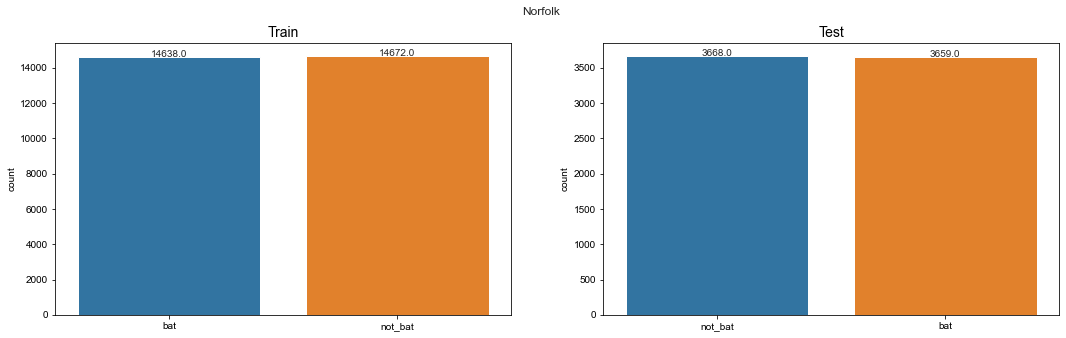

In [20]:
f, axes = plt.subplots(1, 2, figsize = (18,5))
sns.set_style('darkgrid')
sns.countplot(x = train_labels, ax=axes[0])
lb = axes[0].get_xlabel()
axes[0].set_xlabel(lb, fontsize=15)
axes[0].set_title("Train", size = 14)

sns.set_style('darkgrid')
sns.countplot(x = test_labels, ax=axes[1])
lbt = axes[1].get_xlabel()
axes[1].set_xlabel(lbt, fontsize=15)
axes[1].set_title("Test", size = 14)
plt.suptitle(test_set.capitalize())

for ax in axes:
    for p in ax.patches:
        #ax.annotate('{}'.format(p.get_height()), 
        #            ((p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center',))
        ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center')

In [21]:
train_labels_bin = [classes.index(lab) for lab in train_labels]
test_labels_bin  = [classes.index(lab) for lab in test_labels]

In [22]:
len(train_labels_bin)

29310

In [23]:
train_features.shape

(29310, 260, 36, 1)

In [24]:
train_ds   = tf.data.Dataset.from_tensor_slices((train_features, train_labels_bin))
test_ds    = tf.data.Dataset.from_tensor_slices((test_features, test_labels_bin))
batch_size = 128
train_ds   = train_ds.batch(batch_size)
test_ds    = test_ds.batch(batch_size)

In [25]:
input_shape = train_features.shape[1:]

In [26]:
small_cnn = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(2, activation = 'softmax'),
    ])
small_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 258, 34, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 17, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 15, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 7, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 7056)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [27]:
small_cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
    metrics   = 'accuracy',#tf.keras.metrics.SparseCategoricalAccuracy(),
)

In [28]:
EPOCHS  = 25
history = small_cnn.fit(train_ds, 
    validation_data = test_ds,  
    epochs          = EPOCHS,
    callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/25
229/229 [==============================] - 37s 160ms/step - loss: 0.6860 - accuracy: 0.6602 - val_loss: 0.6321 - val_accuracy: 0.7112
Epoch 2/25
229/229 [==============================] - 42s 183ms/step - loss: 0.5925 - accuracy: 0.7302 - val_loss: 0.5742 - val_accuracy: 0.7408
Epoch 3/25
229/229 [==============================] - 51s 223ms/step - loss: 0.5471 - accuracy: 0.7568 - val_loss: 0.5312 - val_accuracy: 0.7669
Epoch 4/25
229/229 [==============================] - 48s 209ms/step - loss: 0.5118 - accuracy: 0.7826 - val_loss: 0.4997 - val_accuracy: 0.7846
Epoch 5/25
229/229 [==============================] - 44s 193ms/step - loss: 0.4815 - accuracy: 0.8041 - val_loss: 0.4703 - val_accuracy: 0.8022
Epoch 6/25
229/229 [==============================] - 46s 202ms/step - loss: 0.4596 - accuracy: 0.8179 - val_loss: 0.4493 - val_accuracy: 0.8115
Epoch 7/25
229/229 [==============================] - 52s 228ms/step - loss: 0.4413 - accuracy: 0.8292 - val_loss: 0.4287 - val_ac

In [29]:
metrics = history.history

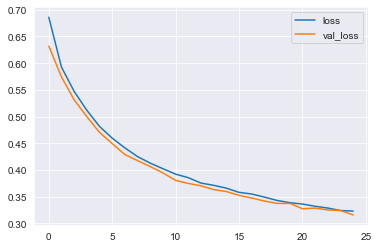

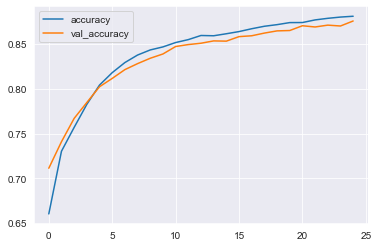

In [30]:
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [31]:
from datetime import datetime

In [32]:
model_name = datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'_'+test_set+'_shallow_net.h5'

In [33]:
small_cnn.save(model_name)

In [34]:
small_cnn.evaluate(test_ds)

58/58 [==============================] - 4s 61ms/step - loss: 0.3158 - accuracy: 0.8757


[0.31576499342918396, 0.8756653666496277]

In [46]:
#need to chop off top of cnn to work with different number of input channels
choices = ['AbsRe', 'AbsIm']

In [36]:
train_features_mult, train_labels_mult = get_multichannel_features(train_paths, params, choices=choices)
test_features_mult,  test_labels_mult  = get_multichannel_features(test_paths,  params, choices=choices)

1 / 29344
2935 / 29344
5869 / 29344
8803 / 29344
11737 / 29344
14671 / 29344
17605 / 29344
20539 / 29344
23473 / 29344
26407 / 29344
29341 / 29344
1 / 7336
734 / 7336
1467 / 7336
2200 / 7336
2933 / 7336
3666 / 7336
4399 / 7336
5132 / 7336
5865 / 7336
6598 / 7336
7331 / 7336


In [37]:
train_labels_mult_bin = [classes.index(lab) for lab in train_labels_mult]
test_labels_mult_bin  = [classes.index(lab) for lab in test_labels_mult]

In [38]:
train_ds_mult   = tf.data.Dataset.from_tensor_slices((train_features_mult, train_labels_mult_bin))
test_ds_mult    = tf.data.Dataset.from_tensor_slices((test_features_mult, test_labels_mult_bin))
batch_size      = 128
train_ds_mult   = train_ds_mult.batch(batch_size)
test_ds_mult    = test_ds_mult.batch(batch_size)

In [39]:
small_cnn_config = small_cnn.get_config()
tf_shape = train_features_mult.shape[1:]
small_cnn_config["layers"][0]["config"]["batch_input_shape"] = (None, tf_shape[0], tf_shape[1], tf_shape[2])

This model will be the trained with the parameters from the small_cnn model, but the weights in the first conv layer are copied multiple times to match channels/dimensions

In [41]:
small_cnn_mult = tf.keras.Sequential.from_config(small_cnn_config)

In [42]:
small_cnn_mult.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 258, 34, 16)       304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 17, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 15, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 7, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 7056)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [43]:
#need to copy the weights from other model
#from https://towardsdatascience.com/implementing-transfer-learning-from-rgb-to-multi-channel-imagery-f87924679166
# Expand weights dimension to match new input channels
def multify_weights(kernel, out_channels):
    mean_1d = np.mean(kernel, axis=-2).reshape(kernel[:,:,-1:,:].shape)
    tiled   = np.tile(mean_1d, (out_channels, 1))
    return(tiled)


# Loop through layers of both original model 
# and custom model and copy over weights 
# layer_modify refers to first convolutional layer
def copy_weights_tl(model_orig, custom_model, layer_modify):
    layer_to_modify = [layer_modify]

    conf = custom_model.get_config()
    layer_names   = [conf['layers'][x]['config']['name'] for x in range(len(conf['layers']))]
    input_channel = conf["layers"][0]["config"]["batch_input_shape"][-1]
    #old_input_channel = model_orig.get_config()["layers"][0]["config"]["batch_input_shape"][-1]

    for layer in model_orig.layers:
        if layer.name in layer_names:
            if layer.get_weights() != []:
                target_layer = custom_model.get_layer(layer.name)

                if layer.name in layer_to_modify:    
                    kernels = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
            
                    kernels_extra_channel = multify_weights(kernels, input_channel)
                    #print('kernels_extra_channel', kernels_extra_channel.shape)                                
                    target_layer.set_weights([kernels_extra_channel, biases])
                    target_layer.trainable = False

                else:
                    target_layer.set_weights(layer.get_weights())
                    target_layer.trainable = False

In [47]:
copy_weights_tl(small_cnn, small_cnn_mult, small_cnn_config["layers"][1]['config']['name'])

In [48]:
small_cnn_mult.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
    metrics   = 'accuracy',#tf.keras.metrics.SparseCategoricalAccuracy(),
)

In [49]:
small_cnn_mult.evaluate(test_ds_mult)

58/58 [==============================] - 4s 63ms/step - loss: 0.3172 - accuracy: 0.8848


[0.3172239065170288, 0.8848096132278442]

In [50]:
EPOCHS  = 5
history = small_cnn_mult.fit(train_ds_mult, 
    validation_data = test_ds_mult,  
    epochs          = EPOCHS
)

Epoch 1/5
229/229 [==============================] - 20s 86ms/step - loss: 0.3262 - accuracy: 0.8810 - val_loss: 0.3172 - val_accuracy: 0.8848
Epoch 2/5
229/229 [==============================] - 19s 81ms/step - loss: 0.3256 - accuracy: 0.8818 - val_loss: 0.3172 - val_accuracy: 0.8848
Epoch 3/5
229/229 [==============================] - 19s 81ms/step - loss: 0.3258 - accuracy: 0.8785 - val_loss: 0.3172 - val_accuracy: 0.8848
Epoch 4/5
229/229 [==============================] - 18s 81ms/step - loss: 0.3264 - accuracy: 0.8795 - val_loss: 0.3172 - val_accuracy: 0.8848
Epoch 5/5
229/229 [==============================] - 20s 87ms/step - loss: 0.3263 - accuracy: 0.8794 - val_loss: 0.3172 - val_accuracy: 0.8848


In [51]:
model_name = datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'_'+test_set+'_shallow_net_'+''.join(choices)+'.h5'
small_cnn_mult.save(model_name)

In [52]:
small_cnn_mult_fresh = tf.keras.Sequential.from_config(small_cnn_config)

In [53]:
small_cnn_mult_fresh.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
    metrics   = 'accuracy',#tf.keras.metrics.SparseCategoricalAccuracy(),
)

In [54]:
small_cnn_mult_fresh.evaluate(test_ds_mult)

58/58 [==============================] - 4s 59ms/step - loss: 0.8169 - accuracy: 0.5057


[0.8168514370918274, 0.5056639909744263]

In [55]:
EPOCHS  = 25
history = small_cnn_mult_fresh.fit(train_ds_mult, 
    validation_data = test_ds_mult,  
    epochs          = EPOCHS,
    callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/25
229/229 [==============================] - 47s 206ms/step - loss: 0.6860 - accuracy: 0.6659 - val_loss: 0.6295 - val_accuracy: 0.7164
Epoch 2/25
229/229 [==============================] - 47s 206ms/step - loss: 0.5927 - accuracy: 0.7362 - val_loss: 0.5719 - val_accuracy: 0.7456
Epoch 3/25
229/229 [==============================] - 53s 231ms/step - loss: 0.5420 - accuracy: 0.7666 - val_loss: 0.5247 - val_accuracy: 0.7762
Epoch 4/25
229/229 [==============================] - 49s 216ms/step - loss: 0.5014 - accuracy: 0.7944 - val_loss: 0.4811 - val_accuracy: 0.8009
Epoch 5/25
229/229 [==============================] - 51s 223ms/step - loss: 0.4720 - accuracy: 0.8121 - val_loss: 0.4577 - val_accuracy: 0.8129
Epoch 6/25
229/229 [==============================] - 50s 219ms/step - loss: 0.4487 - accuracy: 0.8253 - val_loss: 0.4332 - val_accuracy: 0.8274
Epoch 7/25
229/229 [==============================] - 53s 233ms/step - loss: 0.4315 - accuracy: 0.8337 - val_loss: 0.4177 - val_ac

In [56]:
model_name = datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'_'+test_set+'_shallow_net_'+''.join(choices)+'_fresh.h5'
small_cnn_mult.save(model_name)

In [57]:
#Trained on multiple channels, evaluate on one channel

In [58]:
small_cnn_mult_config = small_cnn_mult.get_config()
tf_shape = train_features.shape[1:]
small_cnn_mult_config["layers"][0]["config"]["batch_input_shape"] = (None, tf_shape[0], tf_shape[1], tf_shape[2])
small_cnn_mult_single = tf.keras.Sequential.from_config(small_cnn_mult_config)
copy_weights_tl(small_cnn_mult, small_cnn_mult_single, small_cnn_mult_config["layers"][1]['config']['name'])

In [59]:
small_cnn_mult_single.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
    metrics   = 'accuracy',#tf.keras.metrics.SparseCategoricalAccuracy(),
)

In [60]:
small_cnn_mult_single.evaluate(test_ds)

58/58 [==============================] - 5s 73ms/step - loss: 0.3158 - accuracy: 0.8757


[0.31576499342918396, 0.8756653666496277]

In [61]:
EPOCHS  = 5
history = small_cnn_mult_single.fit(train_ds, 
    validation_data = test_ds,  
    epochs          = EPOCHS
)

Epoch 1/5
229/229 [==============================] - 23s 99ms/step - loss: 0.3231 - accuracy: 0.8751 - val_loss: 0.3158 - val_accuracy: 0.8757
Epoch 2/5
229/229 [==============================] - 22s 96ms/step - loss: 0.3247 - accuracy: 0.8740 - val_loss: 0.3158 - val_accuracy: 0.8757
Epoch 3/5
229/229 [==============================] - 22s 95ms/step - loss: 0.3265 - accuracy: 0.8723 - val_loss: 0.3158 - val_accuracy: 0.8757
Epoch 4/5
229/229 [==============================] - 20s 88ms/step - loss: 0.3248 - accuracy: 0.8740 - val_loss: 0.3158 - val_accuracy: 0.8757
Epoch 5/5
229/229 [==============================] - 20s 89ms/step - loss: 0.3272 - accuracy: 0.8720 - val_loss: 0.3158 - val_accuracy: 0.8757


In [62]:
model_name = datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'_'+test_set+'_shallow_net_'+''.join(choices)+'_mult_single.h5'
small_cnn_mult.save(model_name)


Test the following:
- multichannel evaluated on pre-trained single channel model
- multichannel trained for a small number of epochs on  pre-trained single channel model
- multichannel trained from scratch

Test the following:
    
- single channel evaluated on pre-trained multichannel model 
- single channel trained for a small number of epochs on  pre-trained multichannel model 
- single channel trained from scratch 